# System Delay

This script will able to check the round trip delay from the generator to the digitizer.

connect CH1 output to ADC CH1 input

we will create two fast segment in the generator:

SEG1 - mid level DC data

SEG2 - sinus data


we will crate a task that will play SEG1 and SEG2 in an infinite loop. task2 that plays SEG2 will isue a trigger to the ADC.

the delay will be equal to the amount of points that holds the DC level

In [1]:
import os
import sys
srcpath = os.path.realpath('../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

In [2]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

In [3]:
pid = os.getpid()
print('process id {0}'.format(pid))

# Connect to instrument
Debug = False

# Use lib_dir_path = None 
# for default location (C:\Windows\System32)
# Change it only if you know what you are doing

lib_dir_path = None
#lib_dir_path = r'D:\Projects\ProteusAwg.Nitzan\x64\Debug'


admin = TepAdmin(lib_dir_path)

slots = admin.get_slot_ids()
sid = slots[0]
assert(sid < 255)

inst = admin.open_instrument(slot_id=sid)
inst.default_paranoia_level = 2 # 0, 1 or 2

process id 3244


In [4]:
# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print(resp)

# Get the DAC mode (8 bits or 16 bits)
resp = inst.send_scpi_query(':SYST:INF:DAC?')
dac_mode = resp
print('DAC mode {0} '.format(dac_mode))

if dac_mode == 'M0':
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac // 2.0

# Several initializations ..
inst.send_scpi_cmd('*CLS; *RST')
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Tabor Electronics,P2584M,000000220725,1.115.0
DAC 16 bits
0, no error


# Configure Generator

#### Create Two segments

In [5]:
# Build two AWG segment that will be used as innput for the digitizer

cycleLen = 1024
numCycles = 1
segLen = cycleLen * numCycles

# build DC level segment
d = np.full((1,segLen),half_dac)
d = d.astype(data_type)

# download it to segment 1 of channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEF 1,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 1')
# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', d)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

cycleLen = 1024
numCycles = 8
segLen = cycleLen * numCycles

# Build waveform (sine wave)
x = np.linspace(
    start=0, stop=2 * np.pi * numCycles, num=segLen, endpoint=False)

y = (np.sin(x) + 1.0) * half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# download it to segment 2 of channel 1
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':TRAC:DEF 2,' + str(segLen))
inst.send_scpi_cmd(':TRAC:SEL 2')
# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', y)
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error
0, no error


#### Import Task table from a file

In [6]:
######### import TASK table from a file ##############################
# The default directory is: 'C:\Users\<user-name>\Documents\ProteusFiles'
task_table_path = 'SystemDelay.bin'

# Alternatively use absolute path:
mypath = os.path.realpath('.')
task_table_path = os.path.join(mypath, task_table_path)
print('task_table_path: "{0}"'.format(task_table_path))

# Convert the string to byte-array
str_bytes = np.frombuffer(task_table_path.encode(), dtype=np.uint8)

# Select task-table-file
inst.write_binary_data(':TASK:FILE', str_bytes)

# Load task table from the selected file:
inst.send_scpi_cmd(':TASK:FILE:LOAD')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# set task mode
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':SOUR:FUNC:MODE:TASK 1')
inst.send_scpi_cmd(':SOUR:FUNC:MODE:TYPE TASK')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

task_table_path: "C:\Tabor\Proteus\ProteusNotebook\Notebooks\SystemDelay.bin"
0, no error
0, no error


#### DAC clock and output

In [7]:
# change DAC clock

if dac_mode == 'M0': 
    MaxSclk=2.5e9 
else:
    MaxSclk=9e9

cmd = ':SOUR:FREQ {0}'.format(MaxSclk)
inst.send_scpi_cmd(cmd)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# AWG Channl 1 (output) should be connected to Digitizer Channel 1 (input)
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':OUTP ON')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error
0, no error


## ADC Single channel

In [8]:
# Setup the digitizer in single-channels mode
inst.send_scpi_cmd(':DIG:MODE SING')
inst.send_scpi_cmd(':DIG:FREQ 5400MHZ')

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the TASK1 as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')

# Enable capturing data from channel 2
#inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
#inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
#inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')

# Allocate four frames of 4800 samples
numframes, framelen = 4, 4800
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


In [9]:
# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')

time.sleep(1)

# Query the status. a poling should be done here till end of capturing.
# the delay above is sufficient for capturing 4 frames
resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
print(resp)

# Stop the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

1,0,0
0, no error


In [10]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Total size in bytes: 38400

0, no error


<IPython.core.display.Javascript object>


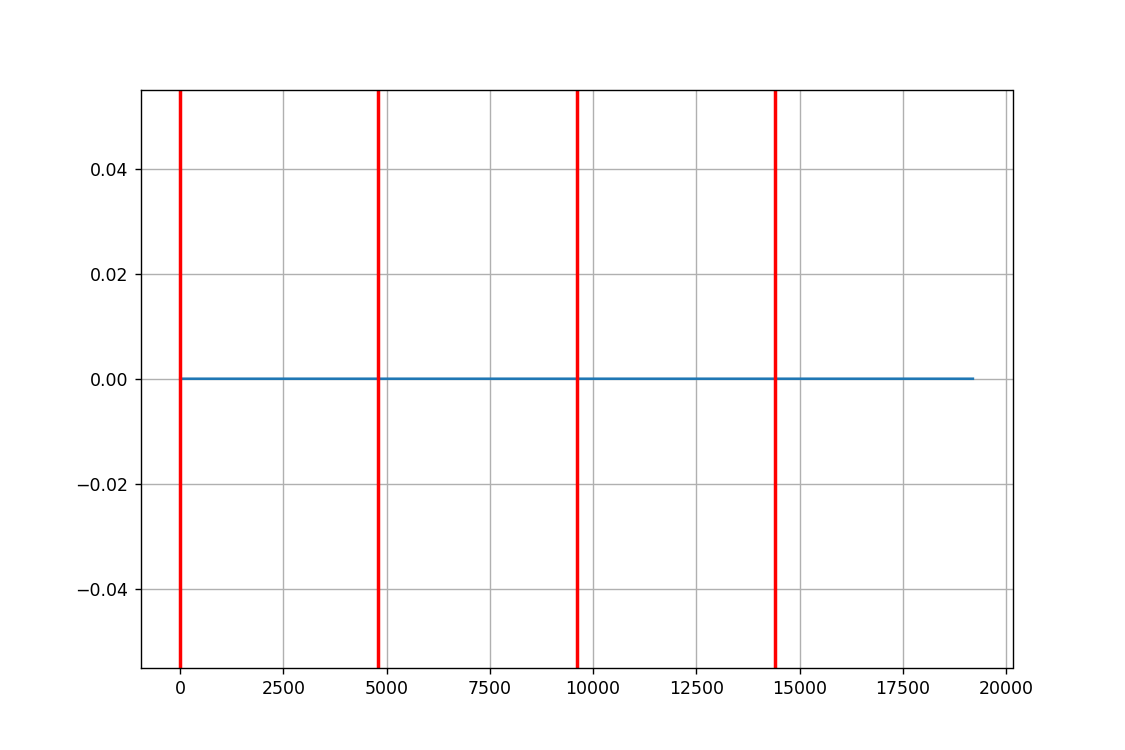

0, no error
0, no error


In [11]:
# Plot the samples
totlen = numframes * framelen
x = range(numframes * framelen)
v = np.linspace(0,totlen,numframes,endpoint=False)
plt.figure(figsize=(9,6))
plt.grid(True)
plt.plot(x, wav1)

for xv in v:
    plt.axvline(x=xv,linewidth=2,color='red')

plt.show()

del wav1

# Clear Frames

cmd = ':DIG:ACQ:ZERO:ALL'
inst.send_scpi_cmd(cmd)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

#free memory

cmd = ':DIG:ACQ:FREE'
inst.send_scpi_cmd(cmd)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

## End

In [1]:
# close connection
inst.close_instrument()
admin.close_inst_admin()

NameError: name 'inst' is not defined